In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.set_default_device("cuda")


In [14]:
########### MODEL CLASSES ###############


class NormalizationLayer(nn.Module):
    def __init__(self, maxnorm, input_shape):
        super(NormalizationLayer, self).__init__()
        self.maxnorm = maxnorm
        #self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        #self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        self.rotation = nn.Sequential(
            nn.Linear(input_shape[1], 8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        self.scaling = nn.Sequential(
            nn.Linear(input_shape[1], 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1),
        )
        
        
    def forward(self, inputs):
        scale_vector = self.sigmoid(self.scaling(inputs))
        rotation_vector = self.rotation(inputs)
        output = inputs * (rotation_vector / torch.norm(rotation_vector, dim=1, p=2, keepdim=True)) * self.maxnorm * scale_vector
        return output
    
class NoiseLayer(nn.Module):
    def __init__(self, noise_radius):
        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = 0.5
        self.beta = 0.5
        
    def spherical_gaussian(self, num_circles):
        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        noise = self.spherical_gaussian(inputs.size(0))
        return inputs + noise
    

class EncoderDecoder(nn.Module):
    def __init__(self, num_circles, larger_radius, smaller_radius):
        super(EncoderDecoder, self).__init__()
        
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = 64
        self.alpha = 0.5

        self.normalize = NormalizationLayer(maxnorm=self.R - self.r, input_shape=(num_circles, 2))       
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_dim),
            nn.SELU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.SELU(),
            nn.Linear(self.main_dim, self.latent_dim),
            nn.Tanh()
        )       
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.main_dim),
            nn.ReLU(),
            nn.Linear(self.main_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        encoded = self.encoder(x)
        normed_encoded = self.normalize(encoded)
        noisy_encoded = self.noise(normed_encoded, alpha, beta)
        decoded = self.decoder(noisy_encoded)
        return decoded

    def centres(self, x):
        return self.normalize(self.encoder(x)).cpu().detach().numpy()

In [15]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [16]:
def plot_circles(centres, large_radius, small_radius, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (2, 2))
    ax.axis('off')
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        #ax.annotate(str(rad+1), (x,y), (x,y), fontsize = 16)
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = 'blue'))
    if save:
        plt.savefig(savename)
    plt.show()

def packing_density(centres, r, R = 1, NumSamples = 100000):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    NumSamples: number of points to be sampled towards density calculation
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R
    
    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(coordinates, [coordinates.shape[0], 1, coordinates.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)
    min_distances = np.min(distances_from_centres, axis = 1)
        
    return np.sum(min_distances < r)/NumSamples

  0%|          | 0/10000 [00:00<?, ?it/s]

Epcoh 0
Packing Density : 0.17784
Circle Config : 


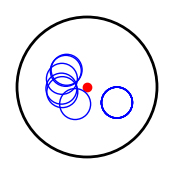

  0%|          | 1/10000 [00:01<4:54:31,  1.77s/it]

##########################


  1%|          | 100/10000 [02:33<4:10:58,  1.52s/it]

Epcoh 100
Packing Density : 0.52736
Circle Config : 


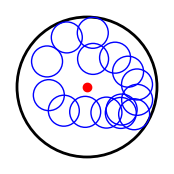

  1%|          | 101/10000 [02:35<4:13:11,  1.53s/it]

##########################


  2%|▏         | 200/10000 [05:03<4:02:15,  1.48s/it]

Epcoh 200
Packing Density : 0.53061
Circle Config : 


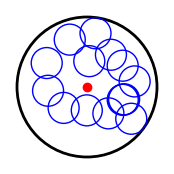

  2%|▏         | 201/10000 [05:05<4:05:42,  1.50s/it]

##########################


  3%|▎         | 300/10000 [07:32<3:45:42,  1.40s/it]

Epcoh 300
Packing Density : 0.56205
Circle Config : 


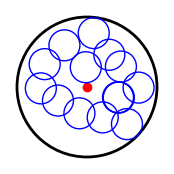

  3%|▎         | 301/10000 [07:33<3:46:30,  1.40s/it]

##########################


  4%|▍         | 400/10000 [10:15<4:31:53,  1.70s/it]

Epcoh 400
Packing Density : 0.55029
Circle Config : 


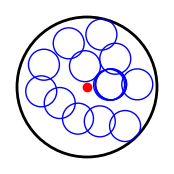

  4%|▍         | 401/10000 [10:17<4:34:00,  1.71s/it]

##########################


  5%|▌         | 500/10000 [12:57<4:11:03,  1.59s/it]

Epcoh 500
Packing Density : 0.52599
Circle Config : 


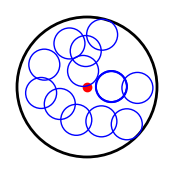

  5%|▌         | 501/10000 [12:59<4:22:33,  1.66s/it]

##########################


  6%|▌         | 600/10000 [15:46<4:19:19,  1.66s/it]

Epcoh 600
Packing Density : 0.55054
Circle Config : 


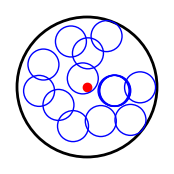

  6%|▌         | 601/10000 [15:48<4:32:03,  1.74s/it]

##########################


  7%|▋         | 700/10000 [18:21<3:51:41,  1.49s/it]

Epcoh 700
Packing Density : 0.5457
Circle Config : 


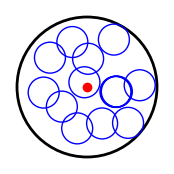

  7%|▋         | 701/10000 [18:22<3:58:15,  1.54s/it]

##########################


  8%|▊         | 800/10000 [21:05<4:19:11,  1.69s/it]

Epcoh 800
Packing Density : 0.55459
Circle Config : 


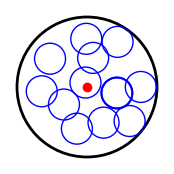

  8%|▊         | 801/10000 [21:07<4:27:43,  1.75s/it]

##########################


  9%|▉         | 900/10000 [23:55<4:21:57,  1.73s/it]

Epcoh 900
Packing Density : 0.56197
Circle Config : 


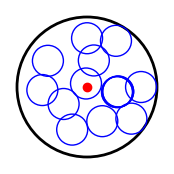

  9%|▉         | 901/10000 [23:57<4:35:52,  1.82s/it]

##########################


 10%|█         | 1000/10000 [26:59<4:27:47,  1.79s/it]

Epcoh 1000
Packing Density : 0.55143
Circle Config : 


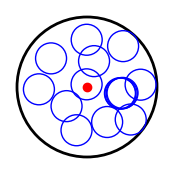

 10%|█         | 1001/10000 [27:01<4:33:47,  1.83s/it]

##########################


 11%|█         | 1100/10000 [29:57<4:07:31,  1.67s/it]

Epcoh 1100
Packing Density : 0.52562
Circle Config : 


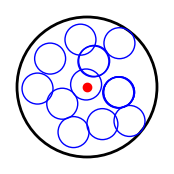

 11%|█         | 1101/10000 [29:59<4:16:44,  1.73s/it]

##########################


 12%|█▏        | 1200/10000 [32:38<4:06:03,  1.68s/it]

Epcoh 1200
Packing Density : 0.52675
Circle Config : 


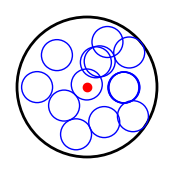

 12%|█▏        | 1201/10000 [32:40<4:11:42,  1.72s/it]

##########################


 13%|█▎        | 1300/10000 [35:21<4:07:29,  1.71s/it]

Epcoh 1300
Packing Density : 0.60176
Circle Config : 


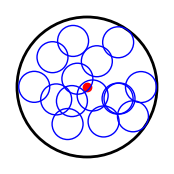

 13%|█▎        | 1301/10000 [35:23<4:10:55,  1.73s/it]

##########################


 14%|█▍        | 1400/10000 [38:05<4:01:53,  1.69s/it]

Epcoh 1400
Packing Density : 0.6229
Circle Config : 


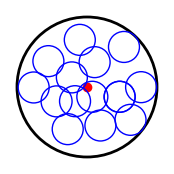

 14%|█▍        | 1401/10000 [38:07<4:08:47,  1.74s/it]

##########################


 15%|█▌        | 1500/10000 [40:49<3:52:21,  1.64s/it]

Epcoh 1500
Packing Density : 0.62669
Circle Config : 


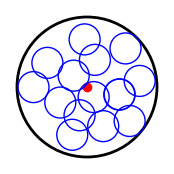

 15%|█▌        | 1501/10000 [40:50<3:55:28,  1.66s/it]

##########################


 16%|█▌        | 1600/10000 [43:28<3:47:06,  1.62s/it]

Epcoh 1600
Packing Density : 0.63006
Circle Config : 


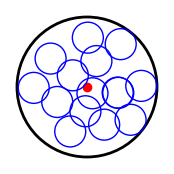

 16%|█▌        | 1601/10000 [43:30<3:52:53,  1.66s/it]

##########################


 17%|█▋        | 1700/10000 [46:05<3:47:11,  1.64s/it]

Epcoh 1700
Packing Density : 0.63841
Circle Config : 


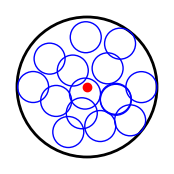

 17%|█▋        | 1701/10000 [46:07<3:48:42,  1.65s/it]

##########################


 18%|█▊        | 1800/10000 [48:45<3:38:28,  1.60s/it]

Epcoh 1800
Packing Density : 0.64047
Circle Config : 


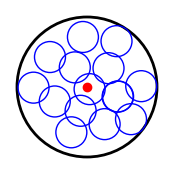

 18%|█▊        | 1801/10000 [48:47<3:40:49,  1.62s/it]

##########################


 19%|█▉        | 1900/10000 [51:28<3:33:38,  1.58s/it]

Epcoh 1900
Packing Density : 0.64535
Circle Config : 


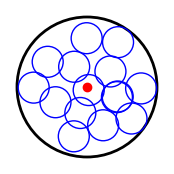

 19%|█▉        | 1901/10000 [51:30<3:38:28,  1.62s/it]

##########################


 20%|██        | 2000/10000 [54:19<3:41:29,  1.66s/it]

Epcoh 2000
Packing Density : 0.64671
Circle Config : 


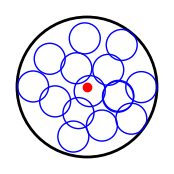

 20%|██        | 2001/10000 [54:21<3:46:32,  1.70s/it]

##########################


 21%|██        | 2100/10000 [57:02<5:09:32,  2.35s/it]

Epcoh 2100
Packing Density : 0.64607
Circle Config : 


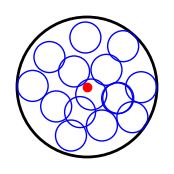

 21%|██        | 2101/10000 [57:04<4:56:56,  2.26s/it]

##########################


 21%|██        | 2102/10000 [57:08<3:34:41,  1.63s/it]


KeyboardInterrupt: 

In [18]:
# Parameters
num_circles = 15
large_radius = 1.0
small_radius = 0.221172539086390937264316484926
BATCHES = 200
EPOCHS = 10000
DEVICE = "cuda"

# Initialize input data and loss function
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1).to(DEVICE)

model = EncoderDecoder(num_circles, large_radius, small_radius).to(DEVICE)


loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
optim2 = torch.optim.Adam(model.parameters(), lr=0.00005)
optim3 = torch.optim.Adam(model.parameters(), lr=0.0000005)
alpha = 2
beta = 8
loss_list = []

# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch == 500 :
        alpha = 4
        beta = 8
    if epoch == 1000 :
        alpha = 8
        beta = 8
    if epoch == 2000 :
        alpha = 2
        beta = 2
    if epoch == 3000 :
        alpha = 1
        beta = 1
    epoch_loss = 0
    if epoch < 4000:
        for inputs in Input:           
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim.step()
            epoch_loss += curr_loss
    if epoch >= 4000 and epoch < 7000:
        for inputs in Input:   
            optim2.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim2.step()
            epoch_loss += curr_loss
    if epoch >= 7000:
        for inputs in Input:   
            optim3.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim3.step()
            epoch_loss += curr_loss
    loss_list.append(epoch_loss.detach().cpu()/BATCHES)
    if epoch % 100 == 0:
        print(f"Epcoh {epoch}") 
        centres = model.centres(eye)
        print(f"Packing Density : {packing_density(centres, small_radius, large_radius)}")
        print(f"Circle Config : ")
        plot_circles(centres, large_radius, small_radius)
        print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [28]:
len(loss_list)

2102

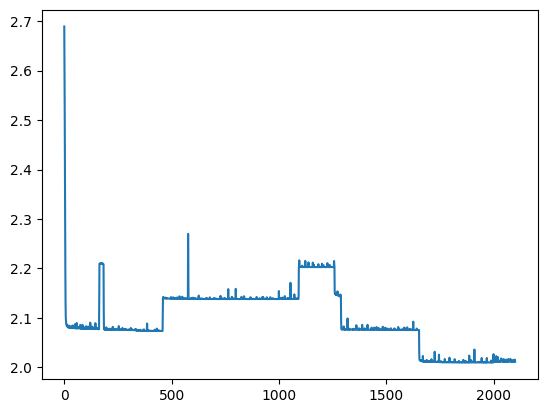

In [29]:
new_list = []
for loss in loss_list:
    new_list.append(loss.cpu().detach())
plt.plot(new_list)
plt.show()

In [ ]:
# ########### MODEL CLASSES ###############


# class NormalizationLayer(nn.Module):
#     def __init__(self, maxnorm, input_shape):
#         super(NormalizationLayer, self).__init__()
#         self.maxnorm = maxnorm
#         self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
#         self.sigmoid = nn.Sigmoid()
#         self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
#     def forward(self, inputs):
#         output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
#         return output
    
# class NoiseLayer(nn.Module):
#     def __init__(self, noise_radius):
#         super(NoiseLayer, self).__init__()
#         self.noise_radius = noise_radius
#         self.alpha = 0.5
        
#     def spherical_gaussian(self, num_circles):
#         x = torch.randn(num_circles, 2)
#         u = torch.rand(num_circles, 1)
#         norm = torch.norm(x, dim=1, keepdim=True, p=2)
#         noise = x * (u.pow(self.alpha)) * self.noise_radius / norm
#         return noise

#     def forward(self, inputs, alpha):
#         self.alpha = alpha
#         noise = self.spherical_gaussian(inputs.size(0))
#         return inputs + noise
    

# class EncoderDecoder(nn.Module):
#     def __init__(self, num_circles, larger_radius, smaller_radius):
#         super(EncoderDecoder, self).__init__()
        
#         self.main_dim = num_circles
#         self.latent_dim = 2
#         self.R = larger_radius
#         self.r = smaller_radius
#         self.mid_dim = 30
#         self.alpha = 0.5

#         self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
#         self.noise = NoiseLayer(self.r)
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.SELU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.SELU(),
#             nn.Linear(self.main_dim, self.latent_dim),
#             nn.Tanh()
#         )       
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.main_dim),
#             nn.ReLU(),
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.ReLU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.Softmax(dim=1)
#         )
        
#     def forward(self, x, alpha):
#         self.alpha = alpha
#         encoded = self.encoder(x)
#         normed_encoded = self.normalize(encoded)
#         noisy_encoded = self.noise(normed_encoded, alpha)
#         decoded = self.decoder(noisy_encoded)
#         return decoded

#     def centres(self, x):
#         return self.normalize(self.encoder(x)).detach().numpy()